# Tutorial Objective

This series of Notebooks are to demostrate how FEAST is integrated as ML Feature Store during the Model Development Journey, especially:

1. Feature Engineering
2. Feature Registration
3. Feature Consumption (Model Training)

## Model

We develop a model that predicts if a credit loan customer can be a bad credit loan using the credit risk dataset.

## Model Development Workflow (Right to Left)

The diagram depicts the model development flow and how FEAST is involved to provide the Feature Store functionality.


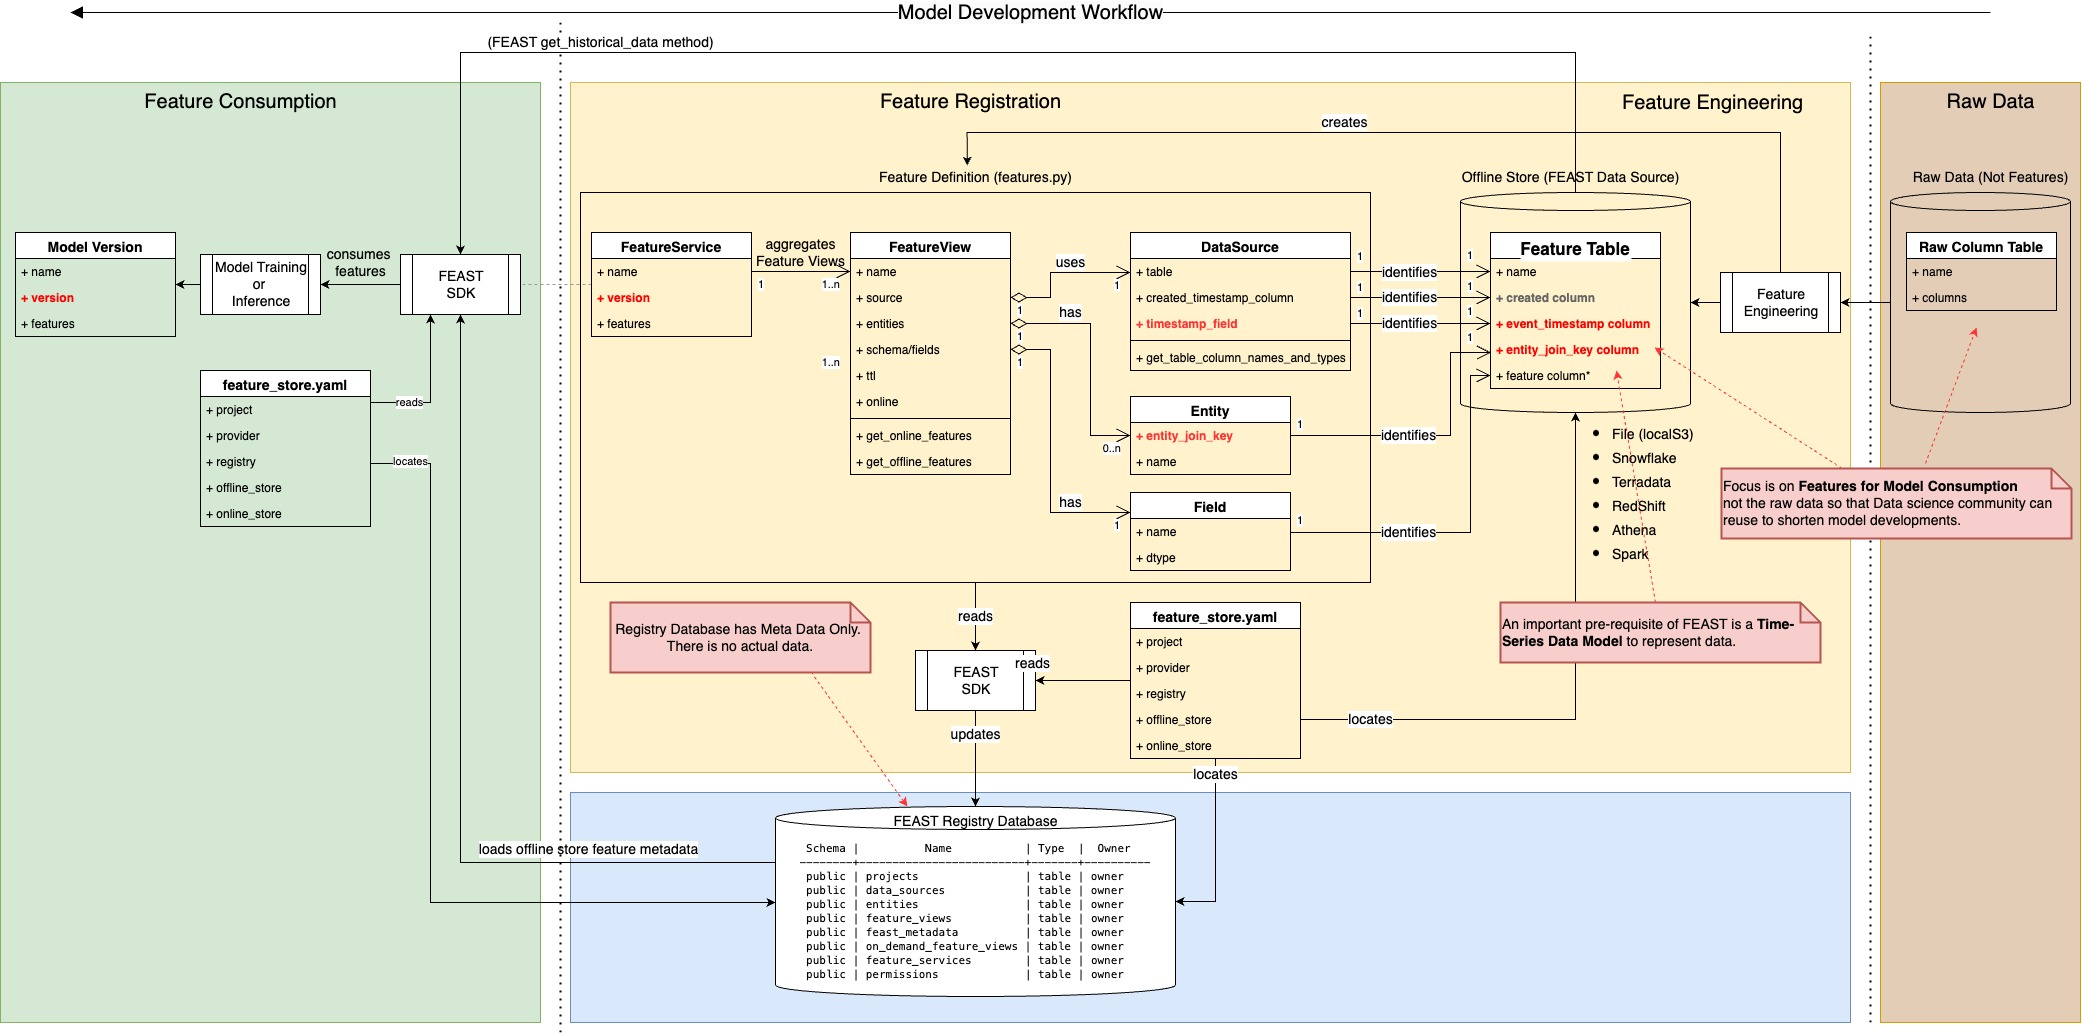

In [1]:
from PIL import Image
from IPython.display import display

img=Image.open("./image/model_development_workflow.jpg")
display(img)

## Dataset

Use the trimmed [Credit risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) to have only:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

See [german-credit-data-with-risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) to see the data in Kaggle.




---
# Local Environment Deployment

The tutorial provides the automated script to setup the environment to run the model development workflow.

<img src="./image/model_development_environment.jpg" align="left"/>

---

# This Notebook (01 Feature Engineering)

This notebook goes through the data exploration and feature engineering to generate the features to be consumed by the model training.

<img src="./image/feature_engineering.png" align="left" width=500/>

---

# Setup

## Note
Install OpenMP runtime on Macbook.
```
brew install libomp
```


In [2]:
from datetime import datetime
import json
import os
import sys
import logging
import warnings

import numpy as np
import pandas as pd

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
warnings.filterwarnings('ignore')

# Show full arrays without truncation
pd.set_option('display.max_colwidth', None)   # Prevent shortening of column values
pd.set_option('display.max_seq_items', None)  # Prevent truncation of sequences
pd.set_option('display.expand_frame_repr', False)  # Keep everything in one line per column
pd.set_option('display.max_columns', None)

In [3]:
pythonpath = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'deployment/feast/feature_repository')
)
if pythonpath not in sys.path:
    sys.path.append(pythonpath)

In [4]:
%load_ext autoreload
%autoreload 2

from eda import (
    run_eda_enrich_pipeline,
    analyse_target_distribution,
    analyse_per_generation,
    analyse_per_property,
    analyse_per_gender,
    analyse_risk_per_saving,
    risk_per_generation,
    risk_per_credit_amount_bin,
    risk_heatmap,
    risk_correlation,
)
from feature_engineering import (
    run_feature_engineering_pipeline,
)
from evaluation import (
    evaluate_model
)
from psql import (
    batch_insert_with_progress,
    exists_table,
    get_all_tables,
    truncate,
    select_one,
)
from utility import (
    read_yaml
)

# Data


In [5]:
df_original = pd.read_csv(
    "../data/raw/german_credit_data.csv",
    index_col=0,
    converters={'Risk': lambda x: {'good': 0., 'bad': 1.}[x]}
)
df_original.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0.0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1.0
2,49,male,1,own,little,NaN,2096,12,education,0.0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0.0
4,53,male,2,free,little,little,4870,24,car,1.0


In [6]:
print(df_original.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   817 non-null    object 
 5   Checking account  606 non-null    object 
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Risk              1000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 85.9+ KB
None


### Column Types

In [7]:
numeric_cols = ['Age', 'Credit amount', 'Duration']
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

### Unique Categorical Values

In [8]:
max_len = max(len(col) for col in categorical_cols)

for col in categorical_cols:
    # Convert unique values to string and join them with commas
    unique_values = df_original[col].dropna().unique()  # optional: remove NaN
    unique_str = ', '.join(str(val) for val in unique_values)
    print(f"{col:<{max_len}} : [{unique_str}]")

Sex              : [male, female]
Job              : [2, 1, 3, 0]
Housing          : [own, free, rent]
Saving accounts  : [little, quite rich, rich, moderate]
Checking account : [little, moderate, rich]
Purpose          : [radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others]


# EDA

## Target label (Risk) and imbalance


In [9]:
df, categorical_cols, numeric_cols = run_eda_enrich_pipeline(
    df=df_original, categorical_cols=categorical_cols, numeric_cols=numeric_cols
)
df.head(1)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Generation,Amount
0,67,male,2,own,NaN,little,1169,6,radio/TV,0.0,Senior,<5K


In [10]:
analyse_target_distribution(df=df)
scale = sum(df['Risk'] == False) / sum(df['Risk'] == True)
scale

2.3333333333333335

## Risk by Credit Amount

Higher the amount, higher the risk.


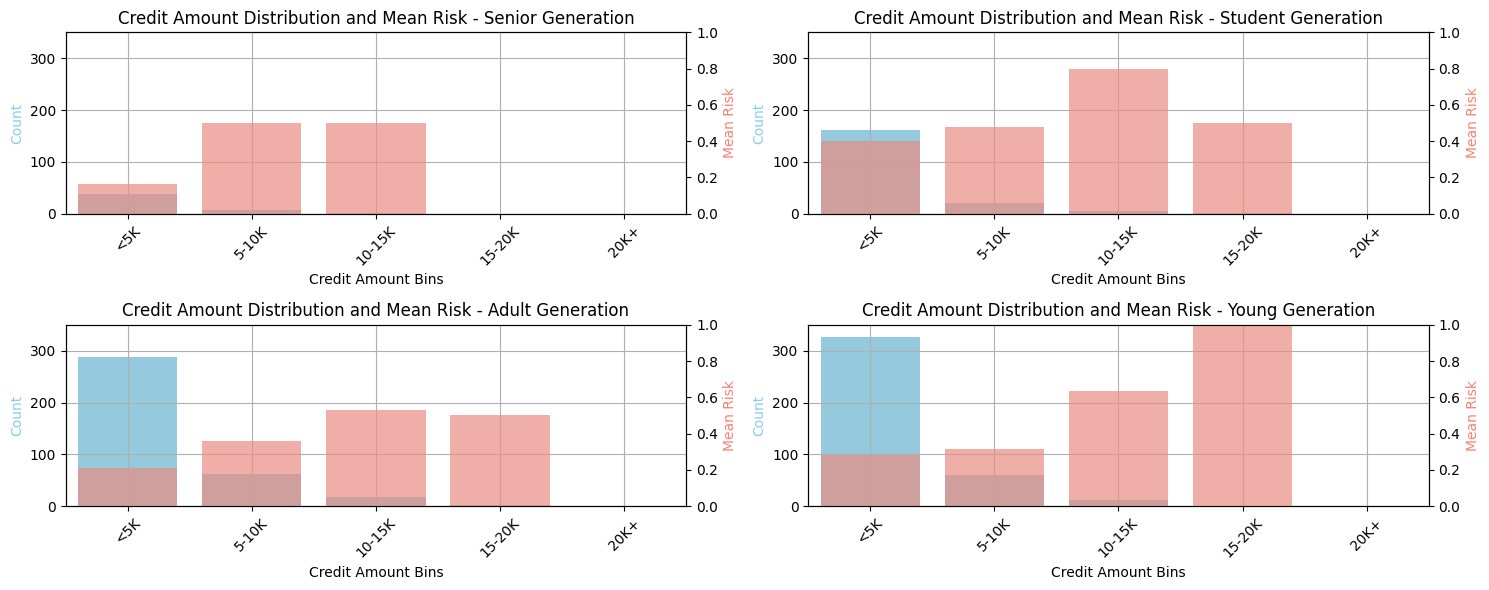

In [11]:
analyse_per_generation(df)
risk_per_credit_amount_bin(df)

# Risk Correlation

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


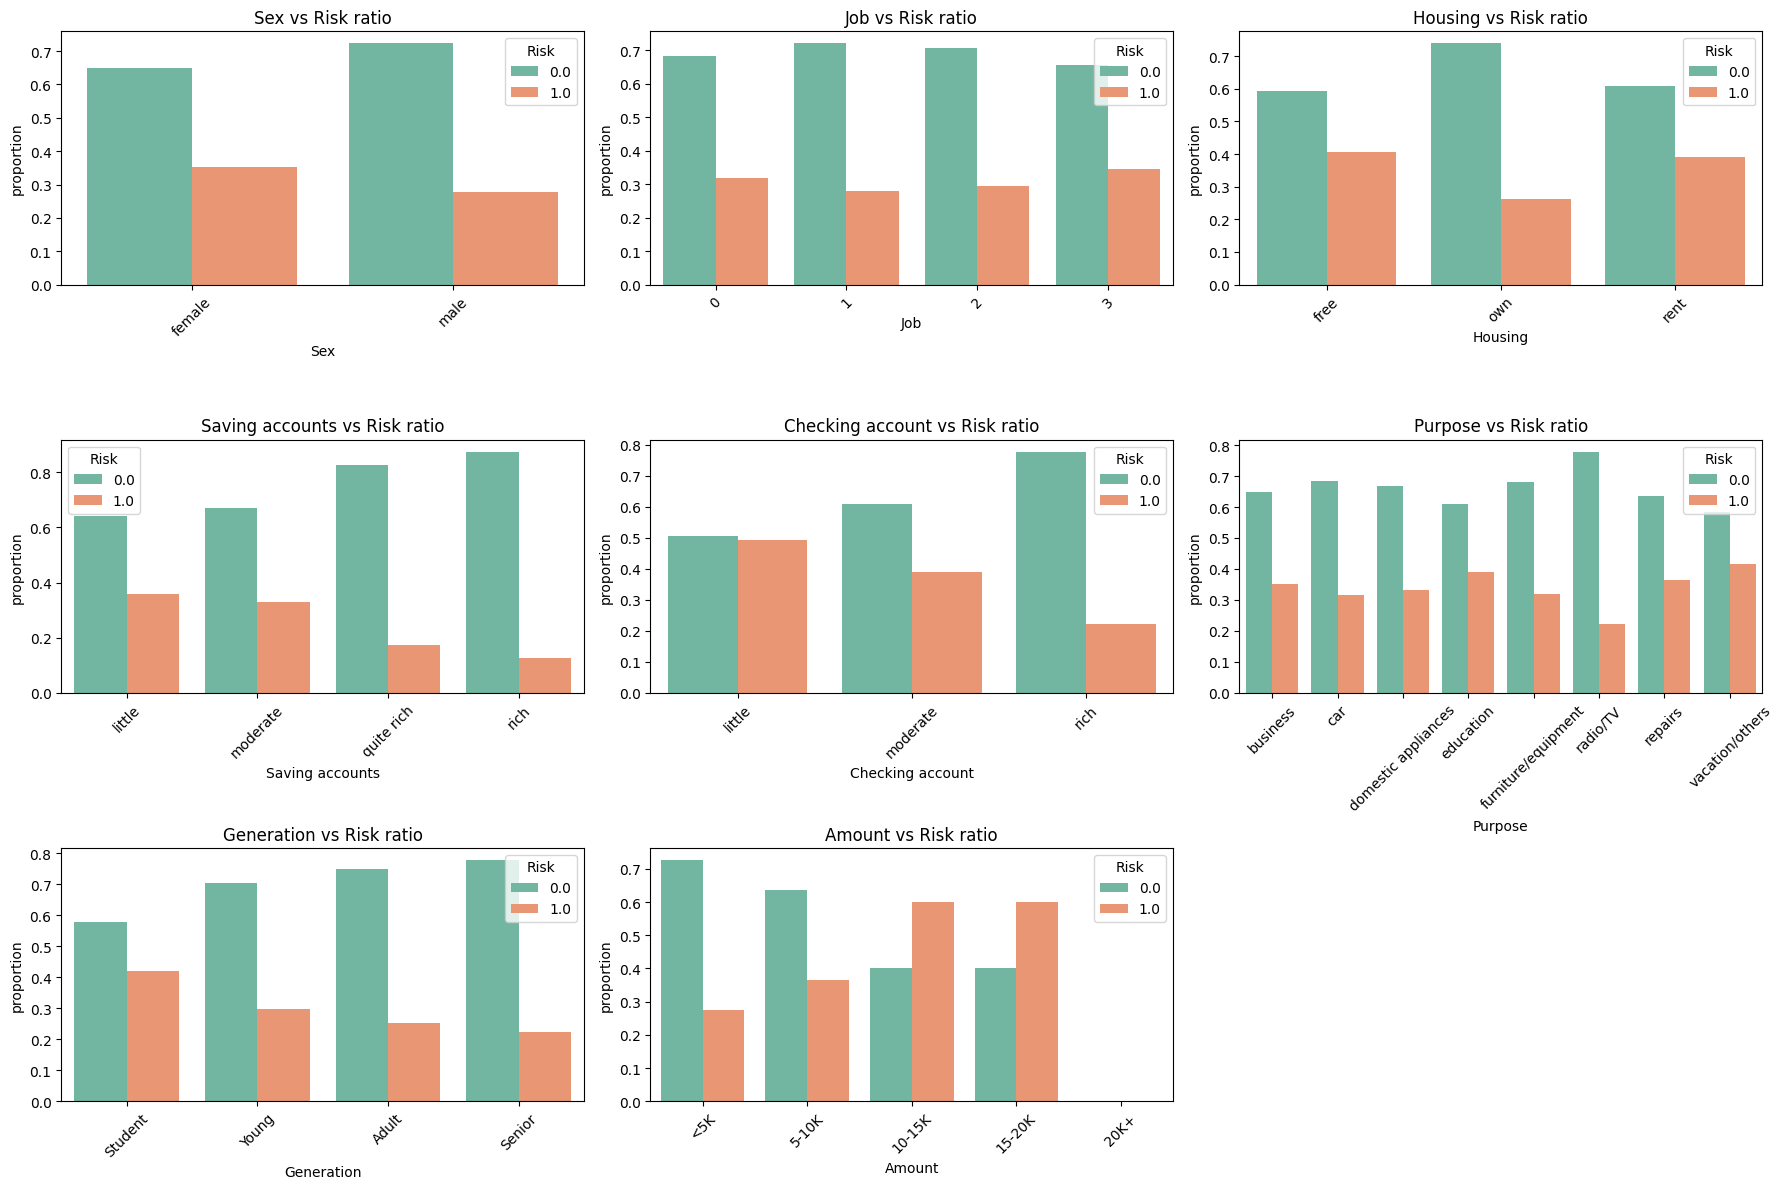

In [12]:
risk_correlation(df, categorical_cols)

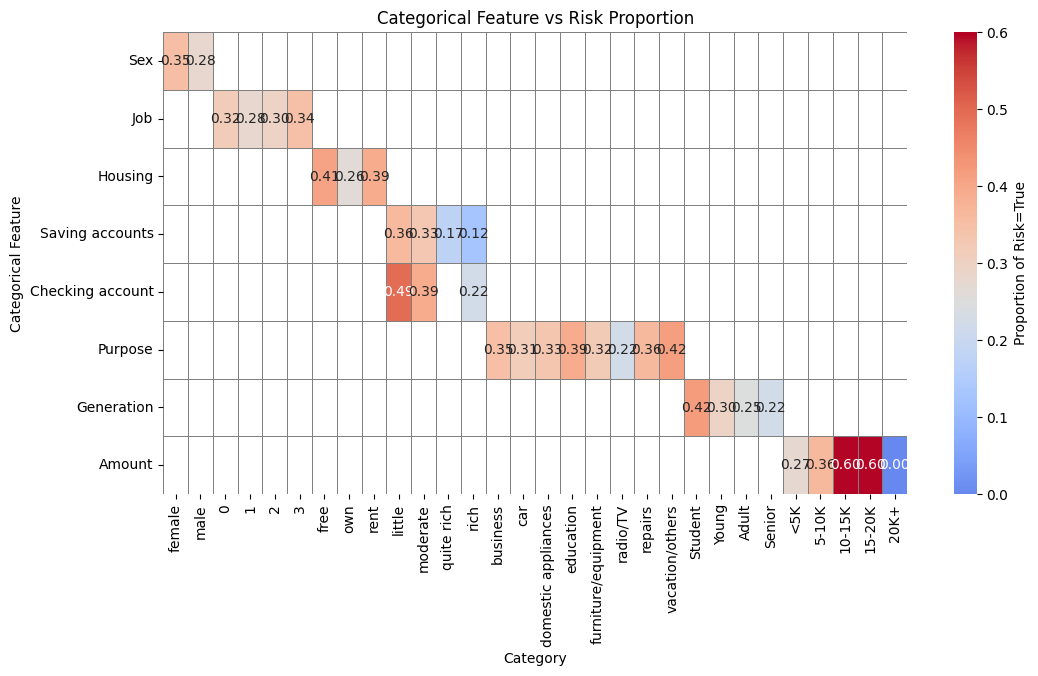

In [13]:
risk_heatmap(df, categorical_cols)

---

# Featur Engineering

NOTE/TODO: Need to set aside the test data.

In [14]:
# Capital letter cause the FEAST feature consumption fail
# Not sure if it is a restriction of FEAST or PostgreSQL.
column_rename_remap = {
    "Risk": "risk",
    "purpose_domestic appliances": "purpose_domestic_appliances",
    "purpose_furniture/equipment": "purpose_furniture_equipment",
    "purpose_radio/TV": "purpose_radio_tv",
    "purpose_vacation/others": "purpose_vacation_others",
    "saving_accounts_quite rich": "saving_accounts_quite_rich",
    "generation_Student": "generation_student",
    "generation_Young": "generation_young",
    "generation_Adult": "generation_adult",
    "generation_Senior": "generation_senior",
    "amount_<5K": "amount_0",
    "amount_5-10K": "amount_1",
    "amount_10-15K": "amount_2",
    "amount_15-20K": "amount_3",
    "amount_20K+": "amount_4",
    "sex_male": "gender_male",
    "sex_female": "gender_female"
}

In [15]:
df_features = run_feature_engineering_pipeline(
    df=df,
    categorical_cols=categorical_cols,
    numeric_cols=numeric_cols,
    label_column='Risk',
    column_rename_map=column_rename_remap
)

# Features for Model Consumption

Verify the features to be consumed by the Model Training

In [16]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   risk                         1000 non-null   float64
 1   gender_female                1000 non-null   float32
 2   gender_male                  1000 non-null   float32
 3   job_0                        1000 non-null   float32
 4   job_1                        1000 non-null   float32
 5   job_2                        1000 non-null   float32
 6   job_3                        1000 non-null   float32
 7   housing_free                 1000 non-null   float32
 8   housing_own                  1000 non-null   float32
 9   housing_rent                 1000 non-null   float32
 10  saving_accounts_little       1000 non-null   float32
 11  saving_accounts_moderate     1000 non-null   float32
 12  saving_accounts_no_inf       1000 non-null   float32
 13  saving_accounts_quite_ri

In [17]:
df_features.head(3)

,risk,gender_female,gender_male,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,generation_student,generation_young,generation_adult,generation_senior,amount_0,amount_1,amount_2,amount_3,amount_4
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Save Features to csv

In [18]:
df_features.to_csv(f"../data/processed/customer_credit_risk_features.csv", index=False)

## Dummpy fields for FEAST

FEAST requires time-series data structure and an entity key of each time-series record.

In [19]:
timestamp = datetime.now()

df_features['event_timestamp'] = pd.Series([timestamp] * len(df))
df_features['created'] = df_features['event_timestamp']
df_features['entity_id'] = range(1, len(df) + 1)

df_features.head(5)

,risk,gender_female,gender_male,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,generation_student,generation_young,generation_adult,generation_senior,amount_0,amount_1,amount_2,amount_3,amount_4,event_timestamp,created,entity_id
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,1
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,2
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,3
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,4
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,5


--- 
# Features to Offline Store


## Offline Store Paramters

In [20]:
feature_store_config = read_yaml("../deployment/feast/feature_repository/feature_store.yaml")
offline_store_config = feature_store_config['offline_store']

offline_store_params = {
    'host': offline_store_config['host'],
    'port': offline_store_config['port'],
    'database': offline_store_config['database'],
    'user': offline_store_config['user'],
    'schema': offline_store_config['db_schema'],
    # table_name must match with the PostgreSQLSource SQL table.
    'table_name': f"{feature_store_config['project']}_offline_features",
}
offline_store_params

INFO:root:Successfully loaded YAML: ../deployment/feast/feature_repository/feature_store.yaml


{'host': 'localhost',
 'port': 5432,
 'database': 'offline_features',
 'user': 'dbadm',
 'schema': 'credit',
 'table_name': 'customer_credit_risk_offline_features'}

## Insert into offline store table

In [21]:
if exists_table(parameters=offline_store_params):
    truncate(parameters=offline_store_params)

batch_insert_with_progress(df=df_features, parameters=offline_store_params)

INFO:root:Table 'credit.customer_credit_risk_offline_features' exists
Engine auto-disposed
Engine auto-disposed
INFO:root:Inserting [1000] rows in [1] batches...


Inserting batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

Successfully inserted all 1000 rows!
Engine auto-disposed


## Verify

In [22]:
columns, record = select_one(parameters=offline_store_params)
df_offline_features = pd.DataFrame(data=[record], columns=columns)

Engine auto-disposed


In [23]:
for col in df_offline_features.columns.to_list():
    print(col)
df_offline_features

risk
gender_female
gender_male
job_0
job_1
job_2
job_3
housing_free
housing_own
housing_rent
saving_accounts_little
saving_accounts_moderate
saving_accounts_no_inf
saving_accounts_quite_rich
saving_accounts_rich
checking_account_little
checking_account_moderate
checking_account_no_inf
checking_account_rich
purpose_business
purpose_car
purpose_domestic_appliances
purpose_education
purpose_furniture_equipment
purpose_radio_tv
purpose_repairs
purpose_vacation_others
generation_student
generation_young
generation_adult
generation_senior
amount_0
amount_1
amount_2
amount_3
amount_4
event_timestamp
created
entity_id


,risk,gender_female,gender_male,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,generation_student,generation_young,generation_adult,generation_senior,amount_0,amount_1,amount_2,amount_3,amount_4,event_timestamp,created,entity_id
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2025-09-17 15:52:17.182670,2025-09-17 15:52:17.182670,1


---
